# Electricity Theft Detection with Real-Time Input using XGBoost


This notebook implements an electricity theft detection pipeline based on the SGCC dataset, using XGBoost for dimensionality reduction. It includes support for:
- Data cleaning and preprocessing
- Synthetic data generation for class balancing
- Feature extraction (time and frequency domain)
- Hyperparameter tuning with Bayesian optimization
- Real-time classification for new consumption records


In [1]:

# !pip install pandas numpy scikit-learn tensorflow scikit-optimize matplotlib


In [2]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.fft import fft
from scipy.interpolate import PchipInterpolator
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, roc_auc_score
from skopt import gp_minimize
from sklearn.preprocessing import StandardScaler
from skopt.space import Integer, Real
from skopt.utils import use_named_args
from imblearn.over_sampling import SMOTE


In [3]:

# The original State Grid Corporation of China (SGCC) dataset used for training models in this project 
# contains 42,372 rows and 1,036 columns. It was utilized for extensive data cleaning and 
# feature selection to train the XGBoost model.

# Due to its large size (~163 MB), it cannot be hosted directly on GitHub, 
# but it is available on Kaggle: https://www.kaggle.com/datasets/bensalem14/sgcc-dataset

# For demonstration and preview purposes, this project uses a smaller version of the SGCC dataset  
# named `datasetsmall.csv`, which contains 25,863 rows and 28 columns, and is approximately 3.8 MB in size.

# Load the dataset
df = pd.read_csv('../data/raw/datasetsmall.csv')  


In [4]:

# I will drop the CONS_NO column since it seems to provide no information as well as being of string type
df = df.drop("CONS_NO", axis=1)

df = df[(df.iloc[:, 1:-1] != 0).any(axis=1)]

def interpolate_row(row):
    x = np.arange(len(row))
    valid = ~row.isna()
    if valid.sum() < 2:
        return row
    f = PchipInterpolator(x[valid], row[valid])
    return pd.Series(f(x))

usage_data = df.iloc[:, 1:-1]
usage_data = usage_data.apply(interpolate_row, axis=1)
df.iloc[:, 1:-1] = usage_data


In [5]:

# Synthetic data generation for class balancing
def generate_synthetic_samples(df_clean, target_col='FLAG'):
    majority = df_clean[df_clean[target_col] == 0]
    minority = df_clean[df_clean[target_col] == 1]
    diff = len(majority) - len(minority)
    if diff <= 0:
        return df_clean
    synthetic = majority.sample(n=diff, random_state=42).copy()
    synthetic_data = synthetic.iloc[:, 1:-1].values * np.random.rand(diff, synthetic.shape[1] - 2)

    synthetic_df = pd.DataFrame(synthetic_data, columns=synthetic.columns[1:-1])
    synthetic_df['FLAG'] = 1
    return pd.concat([df_clean, synthetic_df], ignore_index=True)

df['FLAG'] = df['FLAG'].astype(int)
df = generate_synthetic_samples(df)

# --- Check Balance ---
print("Class distribution after addition:")
print(df['FLAG'].value_counts())


Class distribution after addition:
FLAG
1    20227
0    20227
Name: count, dtype: int64


In [6]:

df.info


<bound method DataFrame.info of        01/01/2014   01/02/2014   01/03/2014   01/04/2014   01/05/2014  \
0          2401.0  2500.000000  2674.000000  2432.000000  2231.000000   
1          3318.0   282.000000   540.000000  5670.000000  4854.000000   
2          1020.8  1097.400000  1377.400000  1408.800000  1414.800000   
3             0.0  1183.800000  1190.400000  1183.800000     0.000000   
4          1445.7  1348.200000  1281.900000  1276.350000  1219.950000   
...           ...          ...          ...          ...          ...   
40449         NaN     3.510679     0.433740     3.758012     2.334194   
40450         NaN     0.325664     0.394699     0.260466     0.904283   
40451         NaN     1.928383     2.446090     0.609735     0.740052   
40452         NaN     3.465591     0.333872     3.113929     5.519036   
40453         NaN     0.000000     0.000000     0.000000     0.000000   

        01/06/2014   01/07/2014   01/08/2014   01/09/2014   01/10/2014  ...  \
0      1942.

In [7]:

# Check the number of instances of each class
class_counts = df['FLAG'].value_counts()
class_counts


FLAG
1    20227
0    20227
Name: count, dtype: int64

Text(0.5, 1.0, 'FLAG Imbalanced Distribution')

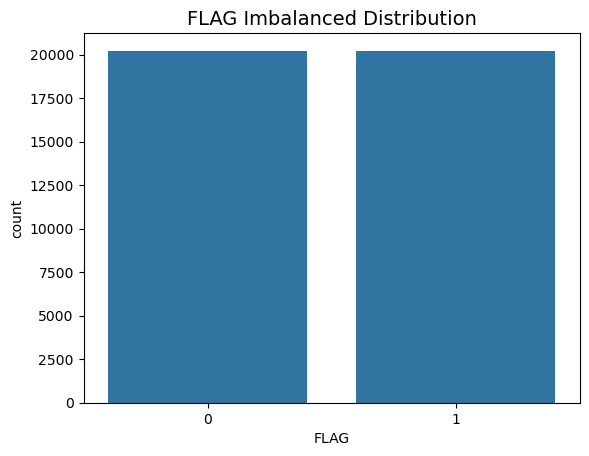

In [8]:

# Now having a balance label
sns.countplot(x=df['FLAG'])
plt.title('FLAG Imbalanced Distribution', fontsize=14)


In [9]:

# Get the number of missing values and percentage
missing_percentage = (df.isna().sum() / len(df)) * 100
print(missing_percentage)

# Assuming your DataFrame is named "data"
missing_values = df.isna().sum()

# To get the total number of missing values in the entire DataFrame
total_missing_values = missing_values.sum()

print("Missing values per column:")
print([x for x in missing_values if x!=0])
print("Total missing values in the DataFrame:", total_missing_values)


01/01/2014    45.325555
01/02/2014     0.000000
01/03/2014     0.000000
01/04/2014     0.000000
01/05/2014     0.000000
01/06/2014     0.000000
01/07/2014     0.000000
01/08/2014     0.000000
01/09/2014     0.000000
01/10/2014     0.000000
01/11/2014     0.000000
01/12/2014     0.000000
1/13/2014      0.000000
1/14/2014      0.000000
1/15/2014      0.000000
1/16/2014      0.000000
1/17/2014      0.000000
1/18/2014      0.000000
1/19/2014      0.000000
1/20/2014      0.000000
1/21/2014      0.000000
1/22/2014      0.000000
1/23/2014      0.000000
1/24/2014      0.000000
1/25/2014      0.000000
1/26/2014      0.000000
FLAG           0.000000
dtype: float64
Missing values per column:
[18336]
Total missing values in the DataFrame: 18336


In [10]:

# Check for columns with missing values
columns_with_missing_values = df.columns[df.isna().any()].tolist()


## Data Cleaning

In [11]:

# Filling missing values with interpolation
df = df.interpolate(method='linear', axis=0)


In [12]:

# Now we check if there's any missing data left
missing_values = df.isna().sum()
print(missing_values.sum())
columns_with_missing_values = df.columns[df.isna().any()].tolist()
print(columns_with_missing_values)


0
[]


In [13]:

df.info


<bound method DataFrame.info of        01/01/2014   01/02/2014   01/03/2014   01/04/2014   01/05/2014  \
0          2401.0  2500.000000  2674.000000  2432.000000  2231.000000   
1          3318.0   282.000000   540.000000  5670.000000  4854.000000   
2          1020.8  1097.400000  1377.400000  1408.800000  1414.800000   
3             0.0  1183.800000  1190.400000  1183.800000     0.000000   
4          1445.7  1348.200000  1281.900000  1276.350000  1219.950000   
...           ...          ...          ...          ...          ...   
40449         0.0     3.510679     0.433740     3.758012     2.334194   
40450         0.0     0.325664     0.394699     0.260466     0.904283   
40451         0.0     1.928383     2.446090     0.609735     0.740052   
40452         0.0     3.465591     0.333872     3.113929     5.519036   
40453         0.0     0.000000     0.000000     0.000000     0.000000   

        01/06/2014   01/07/2014   01/08/2014   01/09/2014   01/10/2014  ...  \
0      1942.

In [14]:

# Feature extraction (time and frequency domain)
def extract_features(row):
    time = row.values
    freq = np.abs(fft(time))[:len(time)//2]
    return pd.Series({
        'energy_mean': time.mean(),
        'energy_std': time.std(),
        'energy_max': time.max(),
        'energy_min': time.min(),
        'energy_range': time.max() - time.min(),
        'energy_freq_mean': freq.mean(),
        'energy_freq_std': freq.std(),
        'energy_freq_max': freq.max(),
        'energy_freq_min': freq.min()
    })

features = df.apply(extract_features, axis=1)


In [15]:

# Adding FLAG Column as Target
features['FLAG'] = df['FLAG']


In [16]:

# Save and Preview
# features.to_csv('../data/processed/extract_features_data.csv', index=False) #Uncomment to save file

print("List of Extracted Features Dataset:")
print(features.columns.tolist())
print(features.head())


List of Extracted Features Dataset:
['energy_mean', 'energy_std', 'energy_max', 'energy_min', 'energy_range', 'energy_freq_mean', 'energy_freq_std', 'energy_freq_max', 'energy_freq_min', 'FLAG']
   energy_mean   energy_std  energy_max  energy_min  energy_range  \
0  1905.814815   788.927638      3167.0         1.0        3166.0   
1  2957.814815  1570.545837      5670.0         1.0        5669.0   
2  1271.037037   279.840431      1540.6         1.0        1539.6   
3   976.288889   409.031138      1228.2         0.0        1228.2   
4  1245.309259   272.800880      1463.1         1.0        1462.1   

   energy_freq_mean  energy_freq_std  energy_freq_max  energy_freq_min  FLAG  
0       7303.433795     12813.027901         51457.00      1408.488504     1  
1      12885.852090     19824.938177         79861.00      1351.763789     1  
2       3953.022031      8773.101764         34318.00       640.274832     1  
3       3945.153948      6508.896557         26359.80      1089.908966    

In [17]:

features.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40454 entries, 0 to 40453
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   energy_mean       40454 non-null  float64
 1   energy_std        40454 non-null  float64
 2   energy_max        40454 non-null  float64
 3   energy_min        40454 non-null  float64
 4   energy_range      40454 non-null  float64
 5   energy_freq_mean  40454 non-null  float64
 6   energy_freq_std   40454 non-null  float64
 7   energy_freq_max   40454 non-null  float64
 8   energy_freq_min   40454 non-null  float64
 9   FLAG              40454 non-null  int64  
dtypes: float64(9), int64(1)
memory usage: 3.1 MB
